# PlagiarismDetection
---

Plagiarism detection tool designed to analyze source code files. [Supporting Java Language]


**Authors**
* José Armando Rosas Balderas | A01704132
* Ramona Najera Fuentes       | A01423596
* Ian Joab Padron Corona      | A01708940

## Libraries

In [1]:
'''
AST Parser
--------------------------------------------------------------------------------------------------
This file contains the code to parse the AST of a given code snippet using tree-sitter.

Authors
--------------------------------------------------------------------------------------------------
  * José Armando Rosas Balderas | A01704132
  * Ramona Najera Fuentes       | A01423596
  * Ian Joab Padron Corona      | A01708940

**Date:** 2025-Apr-28

Libraries
--------------------------------------------------------------------------------------------------
`tree-stitter`: Library for parsing source code into an AST.
`networkx`: Library for creating and manipulating complex networks.
`numpy`: Library for numerical computations in Python.
`matplotlib`: Library for creating static, animated, and interactive visualizations in Python.
`sklearn`: Library for machine learning in Python.
`sys`: Library for system-specific parameters and functions.
`warnings`: Library for issuing warning messages.


Usage
--------------------------------------------------------------------------------------------------
This script is used to parse the AST of a given code snippet using tree-sitter.
It generates a view of the AST, CFG and computes the similarity between 2 given code snippets.
'''
from tree_sitter import Language, Parser
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import sys
import warnings


# Ignore all warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
def set_parserGrammar(parser, lang_grammar, path_grammar):
    """
    Set the language grammar for the parser

    Parameters
    ---
    parser: `Parser`
        The Tree-sitter parser instance

    lang_grammar: `str`
        The programming language grammar ('cpp' or 'java').

    path_grammar: `str`
        The path to the compiled grammar file.
    """
    try:
        parser.set_language(Language(path_grammar, lang_grammar))
    except Exception as e:
        print(f"[ERROR]: Failed to load {lang_grammar} language grammar. {e}")
        sys.exit(1)

In [3]:
def AST_toList(node, level=0, node_list=None):
  """
  Perform a depth-first search (DFS) on the AST and store the nodes in a list.
  
  Preorder traversal is used to visit the nodes

  Parameters
  ---
  node: `Tree Sitter Node` 
    The current node in the AST

  level: `int` 
    The current level in the tree. Default is 0

  node_list: `list` 
    The list to store the nodes. Default is None

  Returns
  ---
  `list` The list of nodes in the AST.
  """
  
  if node_list is None:
      node_list = []
  
  node_list.append((node.type, level))

  # Recursively process child nodes
  for child in node.children:
      AST_toList(child, level + 1, node_list)
  
  return node_list

In [4]:
def AST_toGraph(graph, node, parent=None, counter=[0]):
    """
    Recursively build a graph from a Tree-sitter node

    Parameters
    ---
    
    graph: `Graph`
        The graph to be built
    
    node: `Tree Sitter Node`
        The current node in the AST
    
    parent: `Node`
        The parent node of the current node. Default is None
    
    counter: `list`
        A list to keep track of the node index. Default is [0]
    
    Returns
    ---
    `Graph` The graph built from the Tree-sitter node
    """
    
    idx = counter[0]
    label = node.type
    
    if node.child_count == 0:
        label += f": {node.text.decode('utf8')}"
    graph.add_node(idx, label=label)

    if parent is not None:
        graph.add_edge(parent, idx)

    counter[0] += 1
    
    for child in node.children:
        AST_toGraph(graph, child, idx, counter)

    return graph

In [5]:
def print_ASTNodes(nodes_list):
    """
    Print the nodes of the AST in a readable format to represent the tree structure

    Parameters
    ---
    `list` The list of nodes in the AST
    """
    for node_type, level in nodes_list:
        print(f"{'· ' * level}{node_type}")


In [6]:
def hierarchy_pos(CFGraph, root, width=15., vert_gap=0.5, vert_loc=0, xcenter=0.5):
    """
    Position nodes in a hierarchy layout with increased spacing between nodes at the same level.

    Parameters
    ---
    CFGraph: `Graph`
        The graph to be laid out

    root: `Node`
        The root node of the hierarchy

    width: `float`
        The width of the layout. Default is 2.0 for more spacing

    vert_gap: `float`
        The vertical gap between nodes

    vert_loc: `float`
        The vertical location of the root node

    xcenter: `float`
        The horizontal center of the layout

    Returns
    ---
    `dict` A dictionary mapping nodes to their positions in the layout.
    """
    def _hierarchy_pos(CFGraph, root, leftmost, width, vert_gap, vert_loc, xcenter, pos, parent=None):
        children = list(CFGraph.successors(root))

        if not children:
            pos[root] = (leftmost[0], vert_loc)
            leftmost[0] += width
        else:
            for child in children:
                pos = _hierarchy_pos(CFGraph, child, leftmost, width, vert_gap, vert_loc - vert_gap, xcenter, pos, root)
            mid = (pos[children[0]][0] + pos[children[-1]][0]) / 2
            pos[root] = (mid, vert_loc)

        return pos

    return _hierarchy_pos(CFGraph, root, [0], width, vert_gap, vert_loc, xcenter, {})

In [7]:
def draw_AST(rootNode):
    """
    Draw the AST using NetworkX and Matplotlib.
    
    Parameters
    ---
    `Tree Sitter Node` The root node of the AST.
    """

    # Build a hyerarchical Tree from the AST
    hyerarch_tree = AST_toGraph(nx.DiGraph(), rootNode)

    # hyerarchical Tree Labels
    hyerarch_tree_labels = {n: d['label'] for n, d in hyerarch_tree.nodes(data=True)}

    # Draw the graph
    hyerarch_tree_labels_pos = hierarchy_pos(hyerarch_tree, root=0)
    plt.figure(figsize=(20, 8))

    nx.draw(hyerarch_tree, 
            hyerarch_tree_labels_pos, 
            labels=hyerarch_tree_labels, 
            node_color='lightblue', 
            node_size=1000, 
            font_size=8, 
            arrows=False)

    plt.title("AST")
    plt.show()

In [8]:
def draw_CFG(cfg):
    """
    Draw the Control Flow Graph (CFG) using NetworkX and Matplotlib.
    
    Parameters
    ---
    `Graph` The Control Flow Graph to be drawn.
    """
    
    # Visualization
    CFGraph_pos = nx.spring_layout(cfg)
    CFGraph_labels = nx.get_node_attributes(cfg, 'label')


    plt.figure(figsize=(16, 6))
    nx.draw(cfg, 
            CFGraph_pos, 
            with_labels=True, 
            labels=CFGraph_labels, 
            node_size=2500, 
            node_color='lightgreen', 
            font_size=8, 
            arrows=True)
    plt.title("Java Control Flow Graph (CFG)")
    plt.show()

In [9]:
def merge_CFGs(cfg_dict):
    """
    Given a dictionary of subCFG's, merge all into a single CFG with a 'root' node.

    Parameters
    ---
    cfg_dict: `dict` 
        A dictionary where keys are method names and values are their corresponding CFGs.

    Returns
    ---
    super_cfg: `Graph` A merged CFG with a 'root' node.
    """
    super_cfg = nx.DiGraph()
    root_id = "root"
    super_cfg.add_node(root_id, label="ROOT")

    for method_name, method_cfg in cfg_dict.items():
        # Rename method nodes to avoid conflicts
        renamed_cfg = nx.relabel_nodes(
            method_cfg, 
            lambda n: f"{method_name}_{n}"
        )

        # Merge method graph into the super CFG
        super_cfg.update(renamed_cfg)

        # Find entry node — assume it's the only node with in-degree 0
        entry_nodes = [n for n in renamed_cfg.nodes if renamed_cfg.in_degree(n) == 0]
        if entry_nodes:
            super_cfg.add_edge(root_id, entry_nodes[0], type="method_entry")

    return super_cfg

In [10]:

def build_CFG(tree, source_code, cfg_builder_class):
    """
    Extracts a CFG for each method in a Java class.

    Parameters
    ---
    tree: `Tree Sitter Tree` 
        The Tree-sitter parsed tree

    source_code: `bytes` 
        The raw source code

    cfg_builder_class: `CFGBuilder` 
        The CFGBuilder class to build the CFG

    Returns
    ---
        `dict` Dictionary of {method_name: networkx.DiGraph}
    """
    root = tree.root_node
    method_cfgs = {}

    # Walk the tree and look for method declarations
    def get_method_name(method_node):
        for child in method_node.children:
            if child.type == "identifier":
                return source_code[child.start_byte:child.end_byte].decode("utf-8")
        return "unknown_method"

    # Recursive DFS to find all method_declaration nodes
    def walk_for_methods(node):
        if node.type == "method_declaration":
            method_name = get_method_name(node)

            # Build the CFG from the method body
            node_body = node.child_by_field_name("body")

            # Initialize the CFGBuilder for both files
            builder = cfg_builder_class(source_code)
            builder.build_from_ast(node_body)
            method_cfgs[method_name] = builder.graph
        for child in node.children:
            walk_for_methods(child)

    walk_for_methods(root)
    return method_cfgs

## CFG Class

In [ ]:
class CFGBuilder:
    """
    Class to build a Control Flow Graph (CFG) from a given code snippet using tree-sitter.

    Parameters
    ---
    code: `bytes` The code snippet to be parsed.
    """
    def __init__(self, code: bytes):
        self.graph = nx.DiGraph()
        self.counter = 0
        self.code = code
        self.loop_stack = []  # Holds tuples for break/continue statements
        self.toPrintNodes = []  # Nodes to be appended to the graph

    def generate_label(self, node):
        """
        Generate a label for a node in the AST.
        
        Parameters
        ---
        node: `Tree Sitter Node` The node to generate a label for.
        
        Returns
        ---
        label: `str` The generated label for the node.
        """
        if node.child_count == 0:  # Leaf node
            return node.type
        if node.type == "identifier":
            return node.type
        if node.type == "expression_statement":
            return ''.join(self.generate_label(child) for child in node.children)
        if node.type == "local_variable_declaration":
            return ''.join(self.generate_label(child) for child in node.children)
        if node.type == "switch_label":
            return ''.join(self.generate_label(child) for child in node.children)
        else:  # Non-leaf node
            return ''.join(self.generate_label(child) for child in node.children)

    def get_text(self, node):
        """
        Get the text of a node in the AST.
        
        Parameters
        ---
        node: `Tree Sitter Node` The node to get the text from.
        
        Returns
        ---
        text: `str` The text of the node.
        """
        line = self.code[node.start_byte:node.end_byte].decode("utf-8")
        return line 

    def new_node(self, node, label:str):
        """
        Create a new node in the graph with a unique index and label.

        Parameters
        ---
        label: `str` The label for the new node.
        
        Returns
        ---
        idx: `int` The index of the new node.
        """
        idx = self.counter
        if node.type == "expression_statement":
            label = self.generate_label(node)
        elif node.type == "local_variable_declaration":
            label = self.generate_label(node)
        elif node.type == "if_statement":
            label = f"if {self.generate_label(node.child_by_field_name('condition'))}"
        elif node.type == "for_statement":
            label = ("for "
                    f"{self.generate_label(node.child_by_field_name('init'))} "
                    f"{self.generate_label(node.child_by_field_name('condition'))} "
                    f"{self.generate_label(node.child_by_field_name('update'))}"
                    )
        elif node.type == "while_statement":
            label = f"while {self.generate_label(node.child_by_field_name('condition'))}"
        elif node.type == "identifier":
            label = f"identifier: {node.type}"
        else:
            label = node.type
            if node.child_count == 0 and node.text:
                label += f": {node.text.decode('utf8')}"
        self.graph.add_node(idx, label=label)
        self.counter += 1
        return idx

    def connect_all(self, from_nodes, to_node):
        """
        Connect all nodes `from_nodes` -> `to_node`.
        
        Parameters
        ---
        from_nodes: `list` The list of nodes to connect from.
        
        to_node: `int` The node to connect to.
        """
        for n in from_nodes:
            self.graph.add_edge(n, to_node)

    def build_from_ast(self, node):
        """
        Build the CFG from the AST node.
        
        Parameters
        ---
        node: `Tree Sitter Node` The root node of the AST.
        """
        return self._visit(node)

    def _visit(self, node):
        """
        Visit a node in the AST and build the CFG.
        
        Parameters
        ---
        node: `Tree Sitter Node` The node to visit.
        
        Returns
        ---
        entry: `int` The entry node of the CFG.
        
        exit: `list` The exit nodes of the CFG.
        """
        if node.type == "block":
            prev_exit = []
            entry = None

            for child in node.children:
                if child.is_named:
                    subgraph = self._visit(child)
                    if subgraph["entry"] is not None:
                        if entry is None:
                            entry = subgraph["entry"]
                        if prev_exit:
                            self.connect_all(prev_exit, subgraph["entry"])
                        prev_exit = subgraph["exit"]
            
            return {"entry": entry, "exit": prev_exit}

        elif node.type == "if_statement":
            cond_node = self.new_node(node, f"if {self.get_text(node.child_by_field_name('condition'))}")
            then_branch = self._visit(node.child_by_field_name("consequence"))
            else_node = node.child_by_field_name("alternative")
            
            if else_node:
                else_branch = self._visit(else_node)
                if then_branch["entry"] is not None:
                    self.graph.add_edge(cond_node, then_branch["entry"])
                if else_branch["entry"] is not None:
                    self.graph.add_edge(cond_node, else_branch["entry"])
                exits = then_branch["exit"] + else_branch["exit"]
            
            else:
                if then_branch["entry"] is not None:
                    self.graph.add_edge(cond_node, then_branch["entry"])
                exits = then_branch["exit"] + [cond_node]
            
            return {"entry": cond_node, "exit": exits}

        elif node.type == "while_statement":
            cond_node = self.new_node(node, f"while {self.get_text(node.child_by_field_name('condition'))}")
            body = self._visit(node.child_by_field_name("body"))
            
            self.graph.add_edge(cond_node, body["entry"])
            self.connect_all(body["exit"], cond_node)
            
            self.loop_stack.append((cond_node, []))  # Track exits for break
            _, break_exits = self.loop_stack.pop() # Track exits for break
            
            return {"entry": cond_node, "exit": break_exits + [cond_node]}
        
        elif node.type == "do_statement":
            cond_node = self.new_node(node, f"while {self.get_text(node.child_by_field_name('condition'))}")
            body = self._visit(node.child_by_field_name("body"))

            self.graph.add_edge(cond_node, body["entry"])  # Loop back if condition true
            self.connect_all(body["exit"], cond_node)  # Body to condition

            self.loop_stack.append((cond_node, [])) # Track exits for break
            _, break_exits = self.loop_stack.pop() # Track exits for break

            return {"entry": body["entry"], "exit": break_exits + [cond_node]}

        elif node.type == "for_statement":
            init = self.new_node(node, self.get_text(node.child_by_field_name("init")))
            cond = self.new_node(node, f"for {self.get_text(node.child_by_field_name('condition'))}")
            update = self.new_node(node, self.get_text(node.child_by_field_name("update")))
            body = self._visit(node.child_by_field_name("body"))

            self.graph.add_edge(init, cond)
            self.graph.add_edge(cond, body["entry"])
            self.connect_all(body["exit"], update)
            self.graph.add_edge(update, cond)

            self.loop_stack.append((cond, []))  # Track exits for break
            _, break_exits = self.loop_stack.pop() # Track exits for break
            
            return {"entry": init, "exit": break_exits + [cond]}
        
        elif node.type == "switch_expression":
            cond_node = self.new_node(node, f"switch {self.get_text(node.child_by_field_name('condition'))}")
            body = node.child_by_field_name("body")  # should be a block
            exits = []

            for child in body.children:
                if child.type != "switch_block_statement_group":
                    continue
                
                label_node = None
                group_entry = None
                group_exit = []

                for grandchild in child.children:
                    if grandchild.type == "switch_label":
                        label_node = self.new_node(grandchild, self.get_text(grandchild))
                        self.graph.add_edge(cond_node, label_node)
                    
                    elif grandchild.is_named:
                        subgraph = self._visit(grandchild)
                        
                        if subgraph["entry"] is not None:
                            if group_entry is None:
                                group_entry = subgraph["entry"]
                                if label_node:
                                    self.graph.add_edge(label_node, group_entry)
                            else:
                                self.connect_all(group_exit, subgraph["entry"])
                            
                            group_exit = subgraph["exit"]
                            
                            if grandchild.type == "break_statement":
                                group_exit.append(subgraph["entry"])

                if group_exit:
                    exits += group_exit
            
            return {"entry": cond_node, "exit": exits}

        elif node.type == "try_statement":
            try_block = self._visit(node.child_by_field_name("block"))
            exits = try_block["exit"]

            # Handle catch clauses
            catch_clauses = [c for c in node.children if c.type == "catch_clause"]
            for catch in catch_clauses:
                catch_block = self._visit(catch.child_by_field_name("block"))
                self.connect_all([try_block["entry"]], catch_block["entry"])
                exits += catch_block["exit"]

            # Handle finally
            finally_block = node.child_by_field_name("finally_clause")
            if finally_block:
                final_graph = self._visit(finally_block.child_by_field_name("block"))
                self.connect_all(exits, final_graph["entry"])
                exits = final_graph["exit"]

            return {"entry": try_block["entry"], "exit": exits}
        
        elif node.type == "break_statement":
            brk = self.new_node(node, "break")
            if self.loop_stack:
                _, break_targets = self.loop_stack[-1]
                break_targets.append(brk)
            return {"entry": brk, "exit": []}

        elif node.type == "continue_statement":
            cont = self.new_node(node, "continue")
            if self.loop_stack:
                loop_cond, _ = self.loop_stack[-1]
                self.graph.add_edge(cont, loop_cond)
            return {"entry": cont, "exit": []}
        
        elif node.type == "return_statement":
            ret = self.new_node(node, self.get_text(node))
            return {"entry": ret, "exit": []}
        
        elif node.type in ["block_comment", "line_comment"]:
            return {"entry": None, "exit": []}
        
        else:
            stmt = self.new_node(node, self.get_text(node))
            return {"entry": stmt, "exit": [stmt]}

## Program Constants

In [12]:
# Initialize the parser
parser = Parser()
# Define the constants for the Parser
lang_grammar = 'java'
path_grammar = f'../domain/entities/grammars/{lang_grammar}.so'
# Set the grammar for the parser
set_parserGrammar(parser, lang_grammar, path_grammar)

## TestFile for AST, CFG View

In [13]:
name_file = 'TestCFG.java'
path_file = f'../../resources/datasets/{name_file}'

# Read codes from the provided file path
with open(path_file, 'rb') as f:
    code = f.read()

# Generate the AST for the provided code snippets
tree = parser.parse(code)

## AST Structure

In [14]:
# Generate the list of nodes using DFS
ast_nodes = AST_toList(tree.root_node)

In [15]:
print_ASTNodes(ast_nodes)

program
· class_declaration
· · modifiers
· · · public
· · class
· · identifier
· · class_body
· · · {
· · · method_declaration
· · · · modifiers
· · · · · public
· · · · · static
· · · · integral_type
· · · · · int
· · · · identifier
· · · · formal_parameters
· · · · · (
· · · · · formal_parameter
· · · · · · integral_type
· · · · · · · int
· · · · · · identifier
· · · · · ,
· · · · · formal_parameter
· · · · · · integral_type
· · · · · · · int
· · · · · · identifier
· · · · · )
· · · · block
· · · · · {
· · · · · return_statement
· · · · · · return
· · · · · · binary_expression
· · · · · · · identifier
· · · · · · · +
· · · · · · · identifier
· · · · · · ;
· · · · · }
· · · method_declaration
· · · · modifiers
· · · · · public
· · · · · static
· · · · void_type
· · · · identifier
· · · · formal_parameters
· · · · · (
· · · · · formal_parameter
· · · · · · array_type
· · · · · · · type_identifier
· · · · · · · dimensions
· · · · · · · · [
· · · · · · · · ]
· · · · · · identifier
· · ·

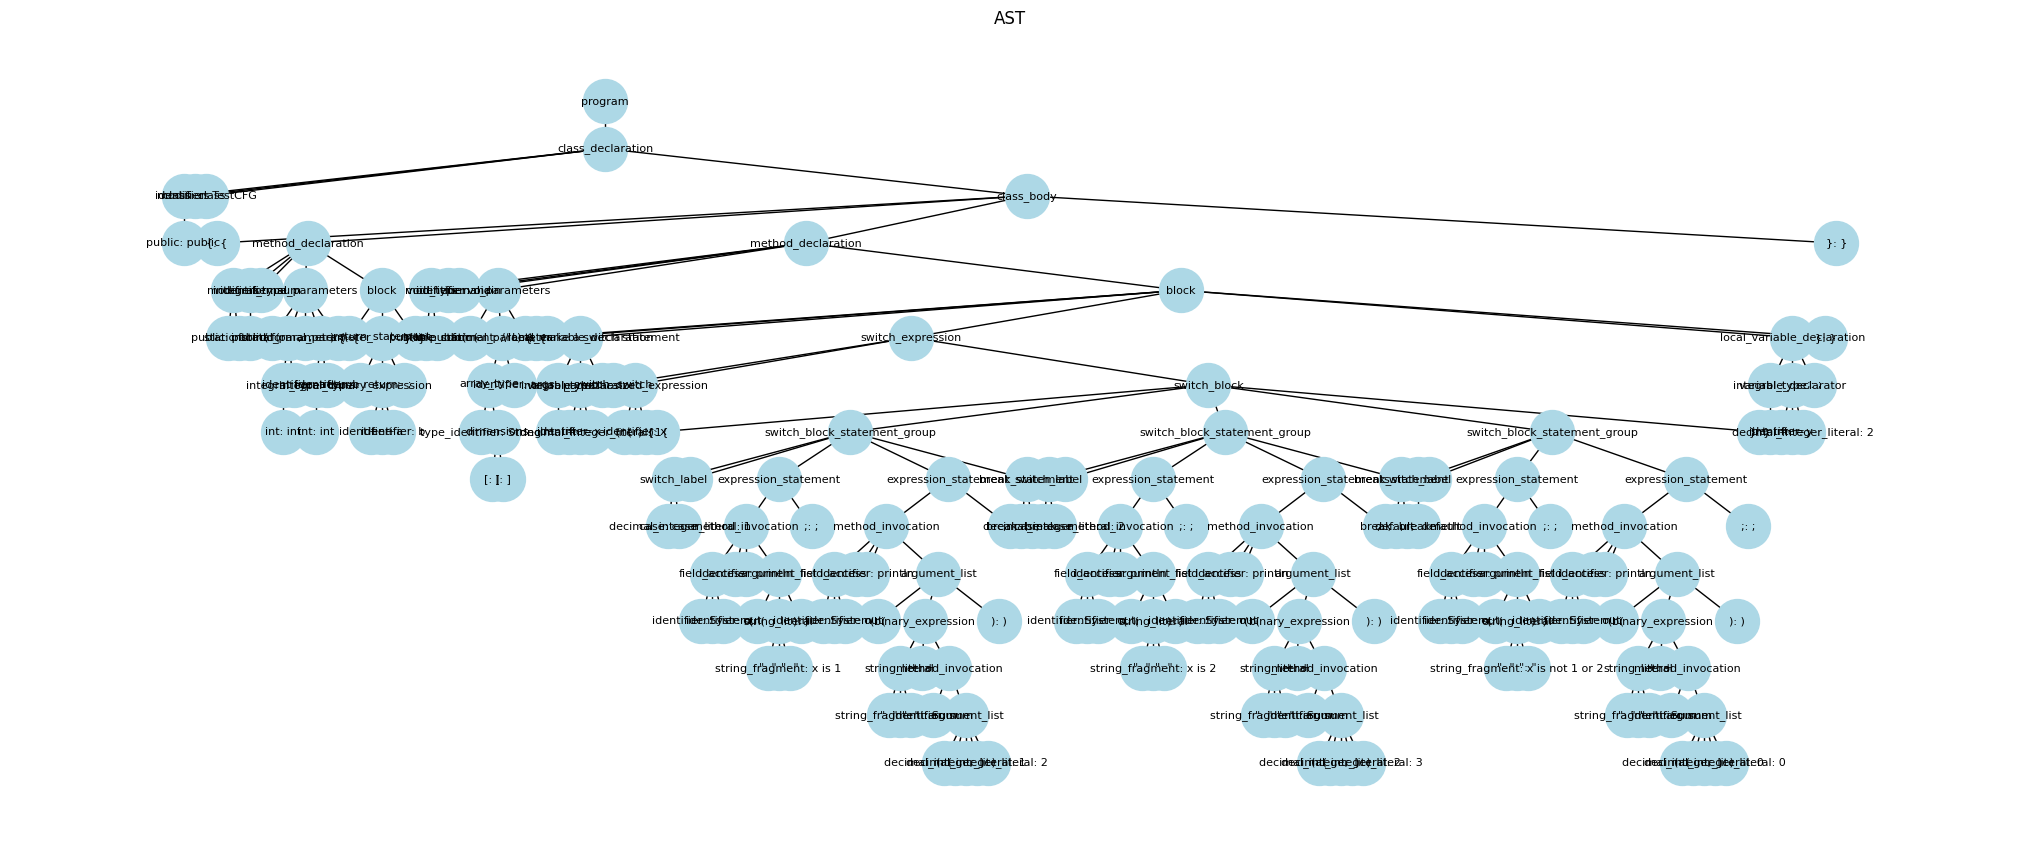

In [16]:
draw_AST(tree.root_node)

## CFG Structure

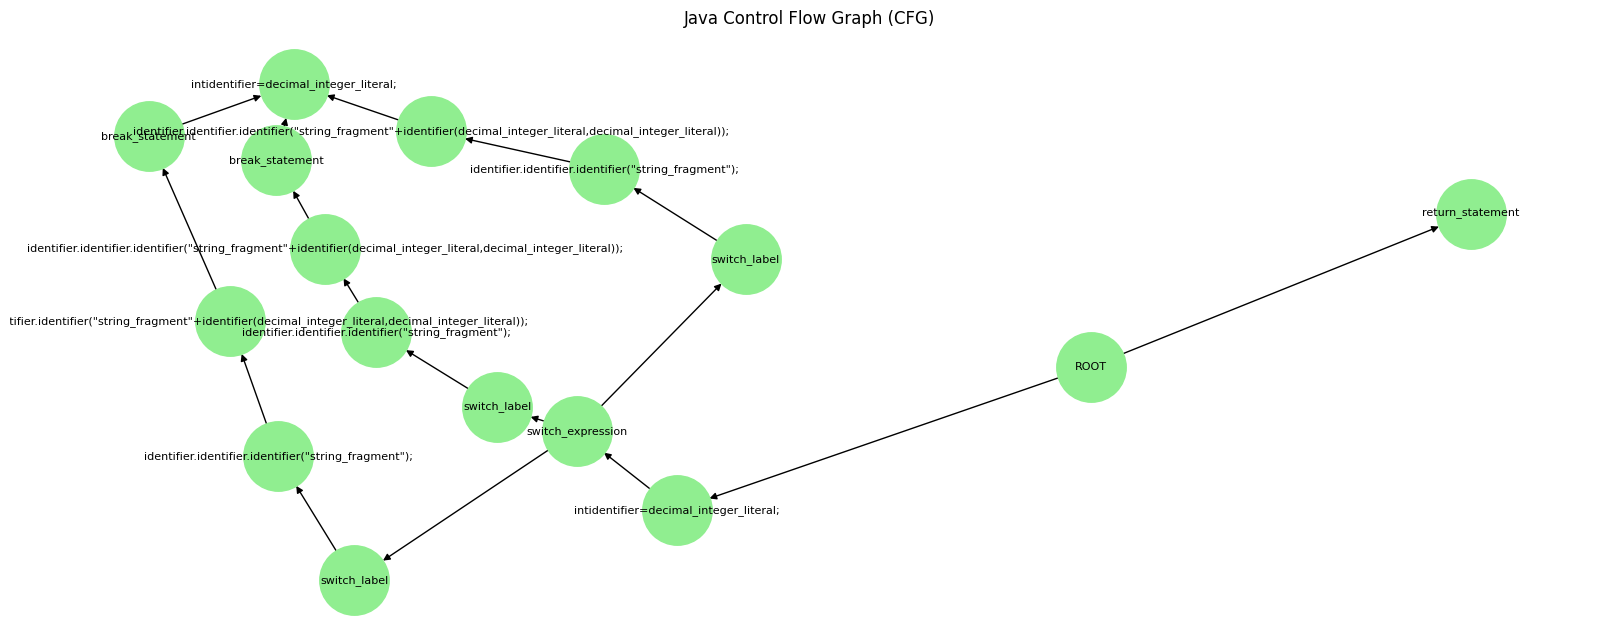

In [17]:
# Initialize the CFGBuilder
CFSubGraphs = build_CFG(tree, code, CFGBuilder)
CFGraph = merge_CFGs(CFSubGraphs)

# Draw the CFG
draw_CFG(CFGraph)

## Markov Chains

In [18]:
def build_TansitionMatrix(G):
    """
    Build a transition matrix from the given directed graph.

    Parameters
    ---
    G: `Graph` The directed graph to build the transition matrix from.
    
    Returns
    ---
    `numpy.ndarray` The transition matrix.
    
    `dict` A mapping from node labels to indices in the matrix.
    """
    nodes = list(G.nodes)
    idx_map = {node: i for i, node in enumerate(nodes)}
    size = len(nodes)
    matrix = np.zeros((size, size))

    for src, dst in G.edges():
        i, j = idx_map[src], idx_map[dst]
        matrix[i][j] += 1

    # Normalize rows to get probabilities
    row_sums = matrix.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        matrix = np.divide(matrix, row_sums, where=row_sums != 0)

    return matrix, idx_map

In [19]:
def flatten_TansitionMatrix(G):
    """
    Flatten the transition matrix of the given directed graph.

    Parameters
    ---
    G: `Graph` The directed graph to build the transition matrix from.

    Returns
    ---
    `numpy.ndarray` The flattened transition matrix.
    """
    # Build the transition matrix
    matrix, _ = build_TansitionMatrix(G)
    return matrix.flatten()


In [20]:
def cfg_cosineSimilarity(cfg1, cfg2):
    """
    Calculate the cosine similarity between two CFGs.

    Parameters
    ---
    cfg1: `Graph` The first CFG.
    
    cfg2: `Graph` The second CFG.
    
    Returns
    ---
    `float` The cosine similarity between the two CFGs.
    """
    vec1 = flatten_TansitionMatrix(cfg1).reshape(1, -1)
    vec2 = flatten_TansitionMatrix(cfg2).reshape(1, -1)

    # Pad to same size if needed
    max_len = max(vec1.shape[1], vec2.shape[1])
    vec1 = np.pad(vec1, ((0, 0), (0, max_len - vec1.shape[1])))
    vec2 = np.pad(vec2, ((0, 0), (0, max_len - vec2.shape[1])))

    return cosine_similarity(vec1, vec2)[0][0]


## GED (Aproximate)

In [21]:
def compute_approximate_ged(cfg1, cfg2, timeout=15.0):
    """
    Compute the approximate Graph Edit Distance between two CFGs using NetworkX.
    
    Parameters
    ---
    cfg1: `Graph` The first CFG.

    cfg2: `Graph` The second CFG.
    
    timeout: `float` Maximum time (in seconds) to spend trying to compute the GED

    Returns
    ---
    `float` The approximate GED, or `None` if it fails.
    """
    try:
        ged = nx.graph_edit_distance(
            cfg1, cfg2, 
            node_match=nx.isomorphism.categorical_node_match('label', default=''),
            edge_match=nx.isomorphism.categorical_edge_match('type', default=''),
            timeout=timeout
        )

        if ged is None:
            return None  # Timeout or no result

        # Estimate max possible GED (very rough upper bound: sum of nodes + edges)
        max_ged = (
            cfg1.number_of_nodes() + cfg2.number_of_nodes() +
            cfg1.number_of_edges() + cfg2.number_of_edges()
        )

        similarity = 1 - (ged / max_ged) if max_ged > 0 else 0.0
        return round(similarity, 4)
    
    except Exception as e:
        print(f"Error during GED computation: {e}")
        return None


## TestFiles for Similarity

In [22]:
# Read codes from the provided file paths
name_file1 = 'TestCFG.java'
name_file2 = 'TestCFG.java'

path_file1 = f'../../resources/datasets/original/{lang_grammar}/{name_file1}'
path_file2 = f'../../resources/datasets/plagarized/{lang_grammar}/{name_file2}'

with open(path_file1, 'rb') as f1:
    code1 = f1.read()

with open(path_file2, 'rb') as f2:
    code2 = f2.read()

# Generate the AST's for the provided code snippets
tree1 = parser.parse(code1)
tree2 = parser.parse(code2)

# Generate the CFG's for the provided code snippets
CFSubGraphs1 = build_CFG(tree1, code1, CFGBuilder)
CFGraph1 = merge_CFGs(CFSubGraphs1)

CFSubGraphs2 = build_CFG(tree2, code2, CFGBuilder)
CFGraph2 = merge_CFGs(CFSubGraphs2)

In [23]:
# Markov-based similarity
simil_m1m2 = cfg_cosineSimilarity(CFGraph1, CFGraph2)
print(f"Markov-based similarity: {simil_m1m2:.4f}")

# Graph Edit Distance (GED) similarity
ged_score = compute_approximate_ged(CFGraph1, CFGraph2)

if ged_score is not None:
    print(f"GED-based similarity: {ged_score:.4f}")
else:
    print("Could not compute similarity (timeout or error).")

Markov-based similarity: 0.6471
GED-based similarity: 0.9211
